In [3]:
import os
os.chdir('/home/vaschetti/maxarSrc/src')
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import sys
import json
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
import numpy as np
#import matplotlib.patches as patches
import matplotlib.pyplot as plt
#import supervision as sv
import requests
import io
import zipfile
from tqdm import tqdm
from time import time

from my_functions.geoDatasets import Maxar
from my_functions.samplers import MyGridGeoSampler
from my_functions.segment import building_gdf, rel_bbox_coords, segment_buildings, rel_road_lines, segment_roads
from my_functions.samplers_utils import boundingBox_2_Polygon



In [4]:
from segment_anything import sam_model_registry, SamPredictor
root = '/home/vaschetti/maxarSrc/'
sam_checkpoint = "models/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=os.path.join(root, sam_checkpoint))
sam.to(device='cuda:0')

predictor = SamPredictor(sam)

In [5]:
data_root = '/mnt/data2/vaschetti_data/maxar'
event_folder = 'Gambia-flooding-8-11-2022'
dataset = Maxar(os.path.join(data_root, event_folder, 'pre/10300100CFC9A500/033133031233.tif'))
sample_size = 600
stride = 400
sampler = MyGridGeoSampler(dataset, size=sample_size, stride=stride)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
dataset_crs = dataset.crs
dataset_res = dataset.res

Creazione dataset e indice edifici

In [6]:
#inserire qui una funzione che legge qualche immagine a caso dalla cartella dell'evento
#e capisce in quale stato si trova. In modo tale da passarlo a building_gdf

In [7]:
state_name = 'TheGambia'
gdfs_32628 = building_gdf(state_name, dataset_crs = dataset_crs)
index_MS_buildings = gdfs_32628.sindex

Found 6 links for TheGambia


Creazione strade

In [8]:
road_links_df = pd.read_csv(os.path.join(root, 'metadata/roads_links.csv'))
region_name = 'Western Africa'
url = road_links_df[road_links_df['region'] == region_name]['link'].values[0]
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
files = zip_file.namelist()

# Assuming the first file in the zip file is the CSV you want to read
with zip_file.open(files[0]) as f:
    road_df = pd.read_csv(f, names =['country', 'geometry'] ,delimiter='\t')
print(road_df.head())

  country                                           geometry
0     BEN  {"type":"Feature","geometry":{"type":"LineStri...
1     BEN  {"type":"Feature","geometry":{"type":"LineStri...
2     BEN  {"type":"Feature","geometry":{"type":"LineStri...
3     BEN  {"type":"Feature","geometry":{"type":"LineStri...
4     BEN  {"type":"Feature","geometry":{"type":"LineStri...


In [9]:
country = 'GMB'
road_df = road_df[road_df['country'] == country]
road_df['geometry'] = road_df['geometry'].apply(json.loads).apply(lambda d: shape(d.get('geometry')))
road_gdf = gpd.GeoDataFrame(road_df, crs=4326)
road_gdf_32628 = road_gdf.to_crs(dataset_crs)

road_point_dist = 40 #50
bg_point_dist = 40 #80
offset_distance = 25 #30

In [10]:
"""path = '/home/vaschetti/maxarSrc/MSRoads/data/AfricaWest-Full/AfricaWest-Full.tsv'
road_df = pd.read_csv(path, names =['country', 'geometry'] ,delimiter='\t')
print(road_df.head())
country = 'GMB'
road_df = road_df[road_df['country'] == country]
road_df['geometry'] = road_df['geometry'].apply(json.loads).apply(lambda d: shape(d.get('geometry')))
road_gdf = gpd.GeoDataFrame(road_df, crs=4326)
road_gdf_32628 = road_gdf.to_crs(dataset_crs)

road_point_dist = 40 #50
bg_point_dist = 40 #80
offset_distance = 25 #30"""

"path = '/home/vaschetti/maxarSrc/MSRoads/data/AfricaWest-Full/AfricaWest-Full.tsv'\nroad_df = pd.read_csv(path, names =['country', 'geometry'] ,delimiter='\t')\nprint(road_df.head())\ncountry = 'GMB'\nroad_df = road_df[road_df['country'] == country]\nroad_df['geometry'] = road_df['geometry'].apply(json.loads).apply(lambda d: shape(d.get('geometry')))\nroad_gdf = gpd.GeoDataFrame(road_df, crs=4326)\nroad_gdf_32628 = road_gdf.to_crs(dataset_crs)\n\nroad_point_dist = 40 #50\nbg_point_dist = 40 #80\noffset_distance = 25 #30"

Creazione Alberi


In [11]:
from groundingdino.util.inference import load_model, predict, annotate
from my_functions.segment import GD_img_load, filter_on_box_area_mt2, segment_from_boxes, GDboxes2SamBoxes

import groundingdino.datasets.transforms as T
GDINO_root ="/home/vaschetti/maxarSrc/models/GDINO"

CONFIG_PATH = os.path.join(GDINO_root, "GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

WEIGHTS_PATH = os.path.join(GDINO_root, "groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

GDINO_model = load_model(CONFIG_PATH, WEIGHTS_PATH, device = 'cuda')

TEXT_PROMPT = 'green tree' #'house' or 'tree' or 'green tree'
BOX_TRESHOLD = 0.15
TEXT_TRESHOLD = 0.30

/home/vaschetti/maxarSrc/models/GDINO/GroundingDINO_SwinT_OGC.py ; exist: True
/home/vaschetti/maxarSrc/models/GDINO/groundingdino_swint_ogc.pth ; exist: True


/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [12]:
GDINO_model.to('cuda')

GroundingDINO(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x DeformableTransformerEncoderLayer(
          (self_attn): MultiScaleDeformableAttention(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout2): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (dropout3): Dropout(p=0.0, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_aff

In [13]:
print('GD model device:', next(GDINO_model.parameters()).device)

GD model device: cuda:0


In [14]:
i = 0
for batch in tqdm(dataloader):
    if i == 8:
        break
    
    #encode the image
    sample = unbind_samples(batch)[0]
    print('sample shape: ', sample["image"].shape)
    img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')
    print('img4sam shape: ', img4Sam.shape)
    print('\n')

    #trees
    image_transformed = GD_img_load(img4Sam)
    i += 1

  0%|          | 4/1936 [00:00<01:01, 31.30it/s]

In sampler
tile_polygon:  POLYGON ((315427.24609375 1485156.25, 320156.25 1485156.25, 320156.25 1479843.75, 315394.8974609375 1479843.75, 315427.24609375 1485156.25))
sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)


sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)


sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)


sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)


sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)


sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)


sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)




  0%|          | 8/1936 [00:00<01:01, 31.48it/s]

sample shape:  torch.Size([3, 600, 600])
img4sam shape:  (600, 600, 3)




In [31]:
import warnings
warnings.filterwarnings('ignore')

i = 0
encoding_times = []
tot_times = []
tot_times_GD = []
for batch in tqdm(dataloader):
    if i == 18:
        break
    s_time_whole = time()
    #encode the image
    sample = unbind_samples(batch)[0]
    img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')

    s_encoding_time = time()
    predictor.set_image(img4Sam)
    tot_encoding_time = time() - s_encoding_time
    encoding_times.append(tot_encoding_time)
    

    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0]) #get the polygon of the sampled bbox
    
    #buildings
    buildig_hits = index_MS_buildings.query(query_bbox_poly)
    #Getting the relative coordinates of the buildings boxes
    if len(buildig_hits) != 0:
        building_boxes = rel_bbox_coords(gdfs_32628.iloc[buildig_hits], query_bbox_poly.bounds, dataset_res, ext_mt=10)

        building_mask, used_boxes, used_points  =  segment_buildings(predictor, building_boxes,
                                                    img4Sam,
                                                    use_bbox=True,
                                                    use_center_points=False)

    #roads
    road_hits = road_gdf_32628.geometry.intersects(query_bbox_poly)
    if len(road_hits) != 0:
        queried_road_gdf_36628 = road_gdf_32628[road_hits]
        road_lines = rel_road_lines(queried_road_gdf_36628, query_bbox_poly, dataset_res)

        road_mask, road_pt_coords4Sam, road_pt_labels4Sam = segment_roads(predictor,
                                                                          road_lines,
                                                                          sample_size,
                                                                          road_point_dist = road_point_dist,
                                                                          bg_point_dist = bg_point_dist,
                                                                          offset_distance = offset_distance,
                                                                          do_clean_mask=True)
    
    #trees
    s_time_GD = time()
    image_transformed = GD_img_load(img4Sam)
    tree_boxes, logits, phrases = predict(GDINO_model, image_transformed, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD)
    tot_times_GD.append(time() - s_time_GD)
    if len(tree_boxes) != 0:
        keep_ix_tree_boxes = filter_on_box_area_mt2(tree_boxes, sample_size, dataset_res, max_area_mt2 = 3000)
        tree_boxes4Sam = GDboxes2SamBoxes(tree_boxes[keep_ix_tree_boxes], sample_size)
        tree_mask, used_tree_boxes, used_tree_points = segment_from_boxes(predictor, tree_boxes4Sam, img4Sam, use_bbox=True, use_center_points=False)
    
    tot_times.append(time() - s_time_whole)

    i+=1
    

  0%|          | 0/1936 [00:00<?, ?it/s]

In sampler
tile_polygon:  POLYGON ((315427.24609375 1485156.25, 320156.25 1485156.25, 320156.25 1479843.75, 315394.8974609375 1479843.75, 315427.24609375 1485156.25))


  1%|          | 18/1936 [00:51<1:31:06,  2.85s/it]


Labelling time

In [16]:
mean_img_encoding_time = np.array(encoding_times).mean()
mean_tot_time = np.array(tot_times).mean()
print("mean_img_encoding_time (s):", mean_img_encoding_time)
print("mean_tot_time (s):", mean_tot_time)
print("img_encoding_time/mean_tot_time:", mean_img_encoding_time/mean_tot_time)

mean_img_encoding_time (s): 2.2438363234202066
mean_tot_time (s): 2.8814875284830728
img_encoding_time/mean_tot_time: 0.778707629736454


In [17]:
print('Extimated time for a single tile (h):', len(dataloader) * mean_tot_time / (60*60))

Extimated time for a single tile (h): 1.549599959762008


In [18]:
print('G Dino time(s): ', np.array(tot_times_GD).mean())

G Dino time(s):  0.251110315322876


Plotting

In [19]:
from my_functions.plotting_utils import show_mask, show_Linestrings, show_points, show_box, plot_comparison

In [32]:
from my_functions import segment
all_masks_no_over = segment.rmv_mask_overlap(np.stack((tree_mask, road_mask, building_mask)))

In [33]:
all_masks_no_over[0].shape

(1, 600, 600)

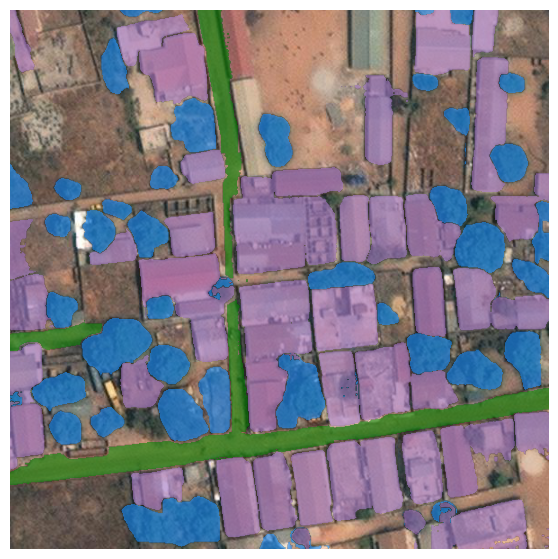

In [35]:
plot_inputs = True
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(img4Sam)

show_mask(all_masks_no_over[0], plt.gca())
show_mask(all_masks_no_over[1], plt.gca(), rgb_color = [0, 128, 0])
show_mask(all_masks_no_over[2], plt.gca(),rgb_color = [160, 116, 196] )

#if plot_inputs:
    #show_Linestrings(road_lines, ax, color='red')
    #show_box(used_boxes, ax, color='r')
    #show_box(used_tree_boxes.tolist(), ax, color='b')
    #show_points(used_tree_points, road_pt_labels4Sam, ax)
    #show_points(road_pt_coords4Sam, road_pt_labels4Sam, ax)
ax.set_xlim([0, sample_size])
ax.set_ylim([sample_size, 0])
plt.axis('off')
save_root = '/home/vaschetti/maxarSrc/output/imgResults/noGambia'
plt.savefig(save_root+'/complete3.png', bbox_inches='tight', pad_inches = 0)
plt.show()

In [ ]:
building_mask.shape

(1, 600, 600)

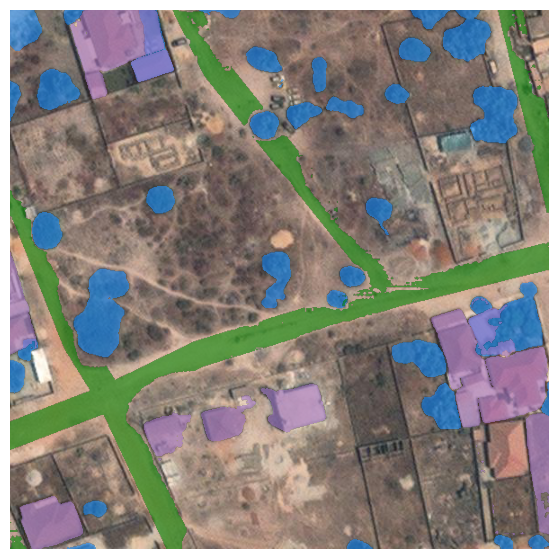

In [ ]:
plot_inputs = True
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(img4Sam)

show_mask(tree_mask, plt.gca())
show_mask(road_mask, plt.gca(), rgb_color = [0, 128, 0])
show_mask(building_mask, plt.gca(),rgb_color = [160, 116, 196] )

#if plot_inputs:
    #show_Linestrings(road_lines, ax, color='red')
    #show_box(used_boxes, ax, color='r')
    #show_box(used_tree_boxes.tolist(), ax, color='b')
    #show_points(used_tree_points, road_pt_labels4Sam, ax)
    #show_points(road_pt_coords4Sam, road_pt_labels4Sam, ax)
ax.set_xlim([0, sample_size])
ax.set_ylim([sample_size, 0])
plt.axis('off')
save_root = '/home/vaschetti/maxarSrc/output/imgResults/complete_mask'
#plt.savefig(save_root+'/roads.png', bbox_inches='tight', pad_inches = 0)
plt.show()

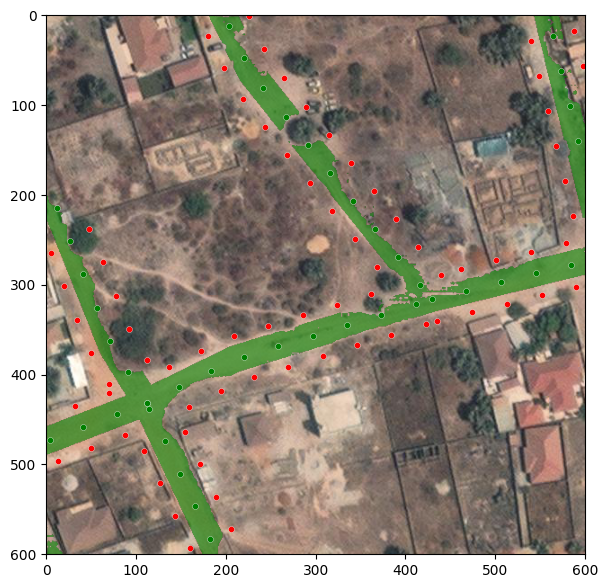

In [ ]:
plot_inputs = True
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(img4Sam)

#show_mask(building_mask, plt.gca())
show_mask(road_mask, plt.gca(), rgb_color = [0, 128, 0])

if plot_inputs:
    #show_Linestrings(road_lines, ax, color='red')
    #show_box(used_boxes, ax, color='b')
    show_points(road_pt_coords4Sam, road_pt_labels4Sam, ax)
ax.set_xlim([0, sample_size])
ax.set_ylim([sample_size, 0])
plt.show()

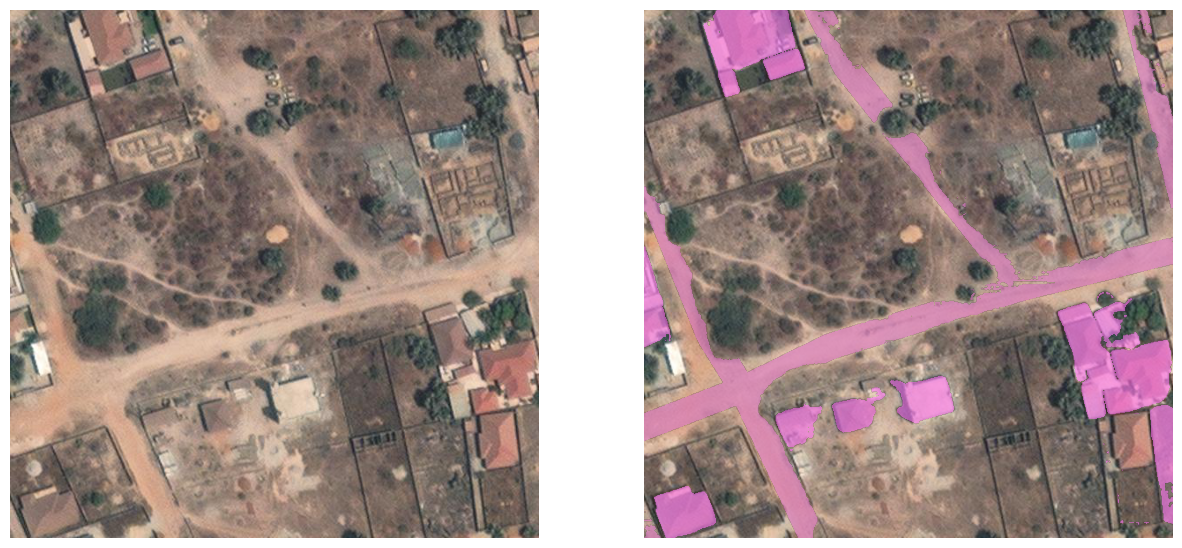

In [ ]:
masks = np.vstack((building_mask, road_mask))
plot_comparison(img4Sam, masks)

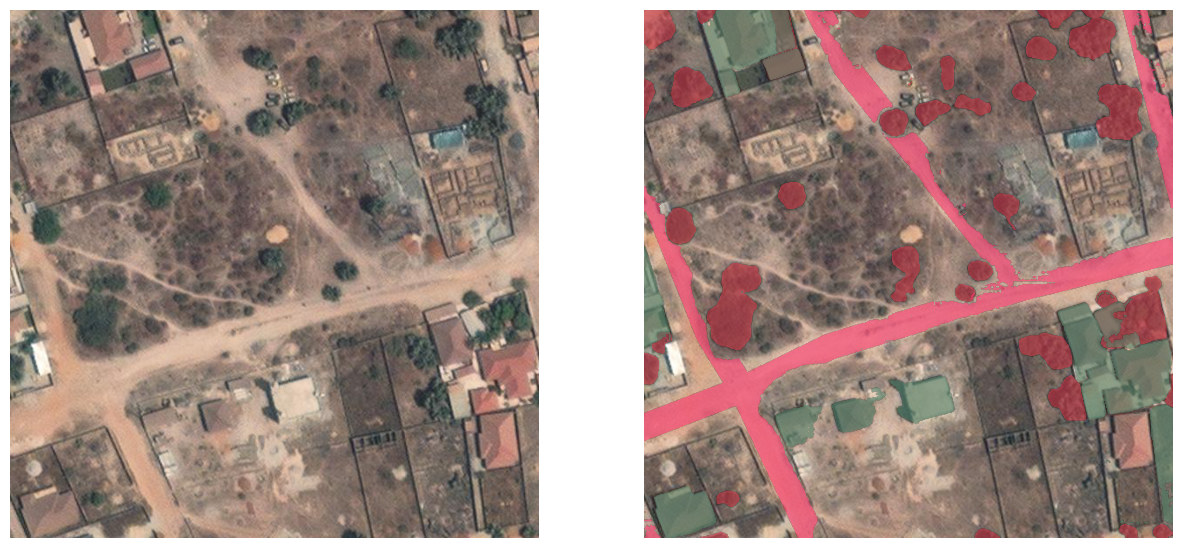

In [ ]:
masks = np.vstack((tree_mask, building_mask, road_mask))
plot_comparison(img4Sam, masks)

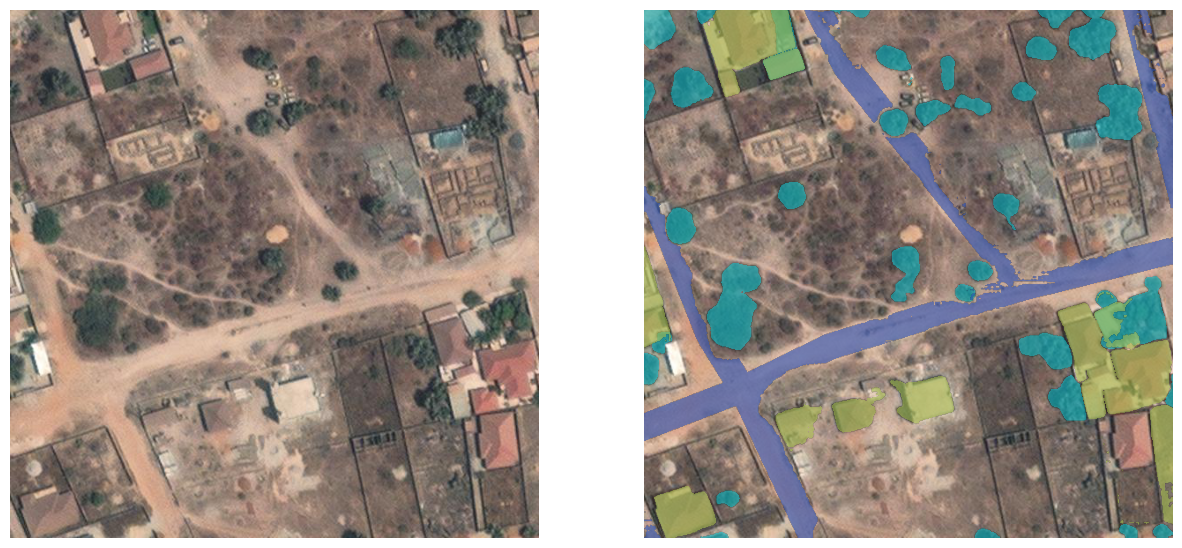

In [ ]:
masks = np.vstack((tree_mask, building_mask, road_mask))
plot_comparison(img4Sam, masks)